In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor,  to_pil_image

from captcha.image import ImageCaptcha
from tqdm import tqdm
import random
import numpy as np
from collections import OrderedDict

import string

characters = '-' + string.digits + string.ascii_uppercase   # 这里‘-’表示空白分割
width, height, n_len, n_classes = 192, 64, 4, len(characters)
n_input_length = 12
print(characters, width, height, n_len, n_classes)

-0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ 192 64 4 37


## 搭建数据集

In [ ]:
class CaptchaDataset(Dataset):

    def __init__(self, characters, length, width, height, input_length, label_length):
        super().__init__()
        self.characters = characters
        self.length = length
        self.width = width
        self.height = height
        self.input_length = input_length
        self.label_length = label_length
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        random_str = ''.join([random.choice(self.characters[1:]) for i in range(self.label_length)])
        image = to_tensor(self.generator.generate_image(random_str))
        target = torch.tensor([self.characters.find(x) for x in random_str], dtype=torch.long) # 是一个数组，每一个元素都是一个idx
        input_length = torch.full(size=(1,), fill_value=self.input_length, dtype=torch.long)
        target_length = torch.full(size=(1,), fill_value=self.label_length, dtype=torch.long)
        return image, target, input_length, target_length

## 测试数据集

XSAF tensor([12]) tensor([4])


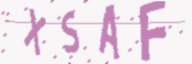

In [3]:
dataset = CaptchaDataset(characters, 1, width, height, n_input_length, n_len)
image, target, input_length, label_length = dataset[0]
print(''.join([characters[x] for x in target]), input_length, label_length)
to_pil_image(image)

## 初始化数据集生成器

In [4]:
batch_size = 128
train_set = CaptchaDataset(characters, 1000 * batch_size, width, height, n_input_length, n_len)
valid_set = CaptchaDataset(characters, 100 * batch_size, width, height, n_input_length, n_len)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=12)
valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=12)

## 初始化模型

In [ ]:
class Model(nn.Module):
    
    def __init__(self, n_classes, input_shape=(3, 64, 128)):
        super().__init__()
        self.input_shape = input_shape  # image的shape， [channel, height, width]
        channels = [32, 64, 128, 256, 256]
        layers = [2, 2, 2, 2, 2]
        kernels = [3, 3, 3, 3, 3]
        pools = [2, 2, 2, 2, (2, 1)]
        modules = OrderedDict()

        def cba(name, in_channels, out_channels, kernel_size):
            modules[f'conv{name}'] = nn.Conv2d(in_channels, out_channels, kernel_size, padding=(1, 1) if kernel_size==3 else 0)
            modules[f'bn{name}'] = nn.BatchNorm2d(out_channels)
            modules[f'relu{name}'] = nn.ReLU(inplace=True)

        last_channel = 3
        for block, (n_channel, n_layer, n_kernel, k_pool) in enumerate(zip(channels, layers, kernels, pools)):
            for layer in range(1, n_layer+1):
                cba(f'{block+1}{layer}', last_channel, n_channel, n_kernel)
                last_channel = n_channel
            modules[f'pool{block + 1}'] = nn.MaxPool2d(k_pool)
        modules[f'dropout'] = nn.Dropout(0.25, inplace=True)

        self.cnn = nn.Sequential(modules)
        self.lstm = nn.LSTM(input_size=self.infer_features(), hidden_size=128, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(in_features=256, out_features=n_classes)


    def infer_features(self): # 跑一次就知道需要适配的大小size是多少了
        x = torch.zeros((1, ) + self.input_shape)  # 加上了一个batch的维度，其中维度值为1
        x = self.cnn(x)  # x.shape: [1, 256, 2, 12]  分别表示batch， channel， height， width
        x = x.reshape(x.shape[0], -1, x.shape[-1])  # 将第二个和第三个维度结合到了一起，变成了3个维度，[1, 512, 12]， 就相当于，把图片竖着分割成了12份。
        return x.shape[1]

    def forward(self, x):
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1]) # 将第二个和第三个维度结合到了一起，变成了3个维度，[b, 512, 12]
        x = x.permute(2, 0, 1)  # 将维度调转，成为[12, b, 512] 分别表示 序列长度（时间长度）， batch， 每个时间步的特征数。
        x, _ = self.lstm(x)  # [12, b, 128 * 2]  分别表示序列长度， batch， 输出的特征维度
        x = self.fc(x)
        return x

## 测试模型输出

In [ ]:
model = Model(n_classes, input_shape=(3, height, width))
inputs = torch.zeros((32, 3, height, width))
outputs = model(inputs)
outputs.shape   # 对应 [序列长度， batch， label_size]

torch.Size([12, 32, 37])

## 初始化模型

In [7]:
model = Model(n_classes, input_shape=(3, height, width))
model = model.cuda()
model

Model(
  (cnn): Sequential(
    (conv11): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu11): ReLU(inplace=True)
    (conv12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu12): ReLU(inplace=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv21): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn21): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu21): ReLU(inplace=True)
    (conv22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn22): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu22): ReLU(inplace=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

## 解码函数和准确率计算函数

In [ ]:
def decode(sequence):
    '''
    根据ctc的规则，将sequence解码成为单词
    就是把重复的单词当做一个，用-作为间隔，最后消除-。
    '''
    a = ''.join([characters[x] for x in sequence])
    s = ''.join(x for j, x in enumerate(a[:-1]) if x != characters[0] and x != a[j+1])
    if len(s) == 0:
        return ''
    if a[-1] != characters[0] and s[-1] != a[-1]:
        s += a[-1]
    return s

def decode_target(sequence):
    return ''.join([characters[x] for x in sequence]).replace(' ', '')

def calc_acc(target, output):
    output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)  # [seq_len, batch, label] => [batch, seq_len, label] => [batch, seq_len]
    target = target.cpu().numpy()   # [batch, num_words_len]
    output_argmax = output_argmax.cpu().numpy()  # [batch, seq_len]
    a = np.array([decode(true) == decode(pred) for true, pred in zip(target, output_argmax)])  # 比较解码后的字符串是否一致，一致是True，不一致是False
    return a.mean()

## 训练模型

In [ ]:
def train(model, optimizer, epoch, dataloader):
    model.train()
    loss_mean = 0
    acc_mean = 0
    with tqdm(dataloader) as pbar:
        for batch_index, (data, target, input_lengths, target_lengths) in enumerate(pbar):
            data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)  # [seq_len, batch, label]

            output_log_softmax = F.log_softmax(output, dim=-1)  # ctc_loss文档要求就是需要概率是log的。

            # output_log_softmax.shape: [seq_len, batch, label] ctc_loss官方文档要求的也是这个顺序
            # target: [batch, num_words_len]
            loss = F.ctc_loss(output_log_softmax, target, input_lengths, target_lengths)  # input_lengths 表示rnn的序列长度， target_lengths表示gt的标准字符长度。

            loss.backward()
            optimizer.step()

            loss = loss.item()
            acc = calc_acc(target, output)

            if batch_index == 0:
                loss_mean = loss
                acc_mean = acc

            loss_mean = 0.1 * loss + 0.9 * loss_mean
            acc_mean = 0.1 * acc + 0.9 * acc_mean

            pbar.set_description(f'Epoch {epoch} Loss: {loss_mean:.4f} Acc: {acc_mean:.4f}')


def valid(model, optimizer, epoch, dataloader):
    model.eval()
    with tqdm(dataloader) as pbar, torch.no_grad():
        loss_sum = 0
        acc_sum = 0
        for batch_index, (data, target, input_lengths, target_lengths) in enumerate(pbar):
            data, target = data.cuda(), target.cuda()

            output = model(data)
            output_log_softmax = F.log_softmax(output, dim=-1)
            loss = F.ctc_loss(output_log_softmax, target, input_lengths, target_lengths)

            loss = loss.item()
            acc = calc_acc(target, output)

            loss_sum += loss
            acc_sum += acc

            loss_mean = loss_sum / (batch_index + 1)
            acc_mean = acc_sum / (batch_index + 1)

            pbar.set_description(f'Test : {epoch} Loss: {loss_mean:.4f} Acc: {acc_mean:.4f}')

In [10]:
optimizer = torch.optim.Adam(model.parameters(), 1e-4, amsgrad=True)
epochs = 15

for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader)
    valid(model, optimizer, epoch, valid_loader)

Test : 15 Loss: 0.0113 Acc: 0.9312: 100%|██████████| 100/100 [00:02<00:00, 42.75it/s]


## 测试模型输出

true Q78H
pred Q78H
true CZJ5
pred CZJ5
true M54C
pred M54C
true 9YCU
pred 9YCU
true HBGL
pred HBGL
true R9QS
pred R9QS
true P6M2
pred P6M2
true O7EY
pred O7EY
true U1IQ
pred U1IQ
true ZP24
pred ZP24
true G3ZN
pred G3ZN
true D8MK
pred D8MK
true TS8W
pred TS8W
true HX7Y
pred HX7Y
true JT52
pred JT52
true JA7W
pred JA7W
true NAFO
pred NAFO
true TO4N
pred TO4N
true NSR0
pred NSR0
true I6SY
pred I6SY
true LESV
pred LESV
true 2O3E
pred 2O3E
true BT8M
pred BT8M
true 24DL
pred 24DL
true 81P9
pred 81P9
true EIDJ
pred EIDJ
true 5GFP
pred 5GFP
true TGTK
pred TGTK
true XALV
pred XALV
true MBNC
pred MBNC
true RYLJ
pred RYLJ
true 7S5C
pred 7S5C
true WTGE
pred WTGE
true 68HK
pred 68HK
true OLK5
pred OLK5
true CAHP
pred CAHP
true 4ZFC
pred 4ZFC
true SD7Y
pred SD7Y
true 8M27
pred 8M27
true 116Z
pred 116Z
true TOUZ
pred TOUZ
true 7LDE
pred 7LDE
true EGS8
pred EGS8
true L5S1
pred L5S1
true 81HS
pred 81HS
true FR0X
pred FR0X
true WFTP
pred WFTP
true E3WG
pred E3WG
true QG6W
pred QG6W
true HDID
pred HDID


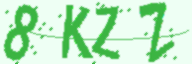

In [12]:
model.eval()
do = True
while do or decode_target(target) == decode(output_argmax[0]):
    do = False
    image, target, input_length, label_length = dataset[0]
    print('true', decode_target(target))

    output = model(image.unsqueeze(0).cuda())
    output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
    print('pred', decode(output_argmax[0]))

to_pil_image(image)

In [13]:
torch.save(model, 'ctc.pth')